In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as sl
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 22})
import semsetup as sem

In [3]:
import pyamg
from pyamg.krylov import gmres

In [4]:
class bc1d:
    def __init__(self,l,r):
        self.l = l
        self.r = r
        self.bcvl = 0.
        self.bcvr = 0.
        
    def __repr__(self):
        return "<BC 1D l:(%s,%f) r:(%s,%f)>" % (self.l,self.bcvl,self.r,self.bcvr)

    def __str__(self):
        return "left(l) is (%s,%f), right(r) is (%s,%f)"\
              % (self.l,self.bcvl,self.r,self.bcvr)
        
    def setdbc(self,loc,dbc):
        if(loc=='l'):
            self.l = 'd'
            self.bcvl = dbc
        elif(loc=='r'):
            self.r = 'd'
            self.bcvr = dbc
            
    def setrbc(self,loc,rbc):
        if(loc=='l'):
            self.l = 'R'
            self.bcvl = rbc
        elif(loc=='r'):
            self.r = 'R'
            self.bcvr = rbc
            
    def setnbc(self,loc,nbc):
        if(loc=='l'):
            self.l = 'n'
            self.bcvl = nbc
        elif(loc=='r'):
            self.r = 'n'
            self.bcvr = nbc
    
    def tostr(self):
        return "%s%s" %(self.l,self.r)

class bc2d():
    def __init__(self,xl,xr,yl,yr):
        self.x = bc1d(xl,xr)
        self.y = bc1d(yl,yr)
        
    def __repr__(self):
        return "<BC 2D: x - %s,%s; y - %s,%s>" % (self.x.l, self.x.r, self.y.l, self.y.r)

    def __str__(self):
        return "2D Boundary conditions: \n x: %s\n y: %s\n" % (repr(self.x), repr(self.y))
        
    def setdbc(self,drc,loc,dbc):
        if(drc=='x'):
            self.x.setdbc(loc,dbc)
        elif(drc=='y'):
            self.y.setdbc(loc,dbc)
    
    def setrbc(self,drc,loc,rbc):
        if(drc=='x'):
            self.x.setrbc(loc,rbc)
        elif(drc=='y'):
            self.y.setrbc(loc,rbc)
            
    def setnbc(self,drc,loc,dbc):
        if(drc=='x'):
            self.x.setnbc(loc,dbc)
        elif(drc=='y'):
            self.y.setnbc(loc,dbc)
    
    def tostr(self):
        return '%s%s%s%s'%(self.x.l,self.x.r,self.y.l,self.y.r)

In [5]:
def sem_adflocop(A,B,D,cx,cy,nu,lxe,lye):
    '''SEM adf operator, local, one element'''
    A2 = nu * ((lye/lxe)*sparse.kron(B,A) + (lxe/lye)*sparse.kron(A,B)).tocsr()
    Ih = sparse.eye(D.shape[0])
    C2 =  sparse.kron(B,B)\
      * ( (lye/2.)*sparse.diags(cx.reshape((-1,),order='F'))*sparse.kron(Ih,D)\
        + (lxe/2.)*sparse.diags(cy.reshape((-1,),order='F'))*sparse.kron(D,Ih))
    L = A2 + C2 # Adv-diff
    B2 = (lxe*lye/4.)*sparse.kron(B,B).tocsr()
    return A2,B2,C2,L

def sem_adfglbop(p,Ex,Ey,cx,cy,nu,lxe,lye):
    '''SEM adf Global Operator, Elem based
    cx, cy: (p+1,p+1,Ex*Ey)'''
    (ah,bh,ch,dh,z,w) = sem.semhat(p)
    nl = p+1
    Lrow, Lcol, Ldata = ([] for i in range(3))
    Brow, Bcol, Bdata = ([] for i in range(3))
    i = 0
    for e in range(Ex*Ey):
        Ae,Be,Ce,Le = sem_adflocop(ah,bh,dh,cx[:,:,e],cy[:,:,e],nu,lxe,lye)
        Lnz = Le.nonzero()
        sparserows = Lnz[0]
        sparsecols = Lnz[1]
        Lrow.extend(np.reshape(sparserows+int(i),-1).tolist())
        Lcol.extend(np.reshape(sparsecols+int(i),-1).tolist())
        Ldata.extend(np.reshape(Le.data,-1).tolist())
        Bnz = Be.nonzero()
        sparserows = Bnz[0]
        sparsecols = Bnz[1]
        Brow.extend((sparserows+int(i)).tolist())
        Bcol.extend((sparsecols+int(i)).tolist())
        Bdata.extend(np.reshape(Be[sparserows,:][:,sparsecols].data,-1).tolist())
        i = i + nl*nl
        
    Ldata = np.array(Ldata)
    Lcol  = np.array(Lcol)
    Lrow  = np.array(Lrow)
    Lge   = sparse.csr_matrix((Ldata, (Lrow, Lcol)),shape=(nl*nl*Ex*Ey,nl*nl*Ex*Ey))

    Bdata = np.array(Bdata)
    Bcol  = np.array(Bcol)
    Brow  = np.array(Brow)
    Bge   = sparse.csr_matrix((np.array(Bdata), (np.array(Brow), np.array(Bcol))),shape=(nl*nl*Ex*Ey,nl*nl*Ex*Ey))
    return Lge, Bge

In [6]:
def ldir2elem(Al,nl,Ex,Ey):
    '''directional array to element based
    input:  Al(nl*Ex,nl*Ey)
    output: Ae(nl,nl,Ex*Ey)
    '''
    if(Al.shape!=(nl*Ex,nl*Ey)):
        print('Wrong input matrix shape! Input shape: %s; Assumed shape: %s\n'%(Al.shape,(nl*Ex,nl*Ey)))
        return None
    Ae = np.zeros((nl,nl,Ex,Ey),order='F',dtype=Al.dtype)
    for je in range(Ey):
        for ie in range(Ex):
            for j in range(nl):
                for i in range(nl):
                    it = i + (ie)*nl
                    jt = j + (je)*nl
                    # print(i,j,ie,je,it,jt,cxl[it,jt])
                    Ae[i,j,ie,je] = Al[it,jt]
    Ae = Ae.reshape((nl,nl,Ex*Ey),order='F')
    return Ae

def elem2ldir(Ae,nl,Ex,Ey):
    '''element based array to directional based
    input:  Ae(nl,nl,Ex*Ey)
    output: Al(nl*Ex,nl*Ey)
    '''
    if(Ae.shape!=(nl,nl,Ex*Ey)):
        print('Wrong input matrix shape! Input shape: %s; Assumed shape: %s\n'%(Ae.shape,(nl,nl,Ex*Ey)))
        return None
    Al = np.zeros((nl*Ex,nl*Ey),order='F',dtype=Ae.dtype)
    for je in range(Ey):
        for ie in range(Ex):
            for j in range(nl):
                for i in range(nl):
                    it = i + (ie)*nl
                    jt = j + (je)*nl
                    et = ie + (je)*Ex
                    
                    Al[it,jt] = Ae[i,j,et]
    # Al = Al.reshape((nl*Ex,nl*Ey),order='F')
    return Al

def genperm(nl,Ex,Ey):
    '''Generate Permutation indices for elem based vector to appear as dir based vector'''
    inddir = np.arange(nl*Ex*nl*Ey,dtype=int).reshape((nl*Ex,nl*Ey),order='F')
    indelm = ldir2elem(inddir,nl,Ex,Ey)
    indnew = indelm.reshape(-1,order='F')
    Perm = np.argsort(indnew,axis=0)
    if(sl.norm(inddir.reshape(-1,order='F') - indnew[Perm],2)>1e-10):
        print('Error in genperm')
        return None
    # generate permutation indices from dir based vector to elem based
    indelm = np.arange(nl*nl*Ex*Ey,dtype=int).reshape((nl,nl,Ex*Ey),order='F')
    inddir = elem2ldir(indelm,nl,Ex,Ey)
    indnew = inddir.reshape(-1,order='F')
    Perm2 = np.argsort(indnew,axis=0)
    if(sl.norm(indelm.reshape(-1,order='F') - indnew[Perm2],2)>1e-10):
        print("Error in genperm for Perm2")
        return None
    return Perm,Perm2

In [102]:
def sempltsurf(X,Y,U,cx,cy,xyrot=225,ifplv=True,zlb='$u$',ifsv=False):
    if(ifplv):
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(121, projection='3d')
        ax.plot_surface(X,Y,U,cmap=cm.jet)
        ax.set_xlabel('$x$',labelpad=20)
        ax.set_ylabel('$y$',labelpad=20)
        ax.set_zlabel('$u$',labelpad=10)
        ax.view_init(30, xyrot)
        ax2 = fig.add_subplot(122)
        ax2.quiver(X,Y,cx,cy)
    else:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X,Y,U,cmap=cm.jet)
        ax.set_xlabel('$x$',labelpad=20)
        ax.set_ylabel('$y$',labelpad=20)
        ax.set_zlabel(zlb,labelpad=10)
        ax.view_init(30, xyrot)
    if(ifsv):
        plt.tight_layout()
        plt.savefig('test1sln.png',bbox_inches='tight')
    return 0

In [10]:
def constant_exc(X,Y,nu,cx,cy):
    from sympy import symbols, exp, diff, lambdify
    x,y,ep = symbols('x y ep')
    u = 0.25*(x+1)*(y+1)*(1-exp((x-1)/(2*ep)))*(1-exp((y-1)/(2*ep)))
    ux = diff(u,x)
    uy = diff(u,y)
    uxx = diff(ux,x)
    uyy = diff(uy,y)
    f = cx*ux + cy*uy - ep*(uxx + uyy) # constant cx, cy
    uex = lambdify((x,y), u.subs(ep,nu), modules='numpy')
    fex = lambdify((x,y), f.subs(ep,nu), modules='numpy')
    uevl = uex(X,Y)
    fevl = fex(X,Y)
    return uevl, fevl

def constant_case1(X,Y,nu):
    f = 1. + 0.*X
    tmp1 = np.exp(-2./nu)
    u = X + (2.*np.exp((X-1.)/nu)-tmp1-1.)/(tmp1-1.)
    return u,f

def adf_coefs(initflg,X,Y):
    if(initflg==1): # one-dimensional problem in two-dimensional grid
        nu = 0.1
        cx = 1. + 0.*X
        cy = 0. + 0.*Y
        bc = bc2d('d','d','n','n')
    elif(initflg==2): # double glazing
        nu = 0.005
        cx =  2.*np.multiply(Y,1.-np.power(X,2))
        cy = -2.*np.multiply(X,1.-np.power(Y,2))
        bc = bc2d('d','d','d','d')
        bc.setdbc('x','r',1.) # Inhomogeneous Dirichlet
    elif(initflg==3): # constant 
        nu = 0.01
        cx = 2. + 0.*X
        cy = 1. + 0.*X
        bc = bc2d('d','d','d','d')
    elif(initflg==4): # pure diffusion
        nu = 0.1
        cx = 0.*X
        cy = 0.*X
        bc = bc2d('d','d','d','d')
    elif(initflg==5): # cool pic
        nu = 0.01
        cx = -X
        cy = Y
        bc = bc2d('d','d','n','n')

    return nu, cx, cy, bc

In [106]:
# initflg:
#  1: 1D problem;  2: rotation field;  3:constant wind
#  4: pure diffusion; 5: varying boundary value
initflg = 3
plist = [7, 11, 15, 19, 23, 27, 31]
# plist = [7, 15, 23, 31, 39, 47, 55, 63] # 63 about crashes the laptop
plist = [15]
# elist = [4, 8, 16, 32, 40, 48, 56, 64]
elist = [4] # Ex, Ey
erl = []
eril = []
er2l = []
for E in elist:
    Ex = E
    Ey = E
    lxe = 2./float(Ex)
    lye = 2./float(Ey)
    for p0 in plist:
        # p0 = 32 # poly order
        nl = p0 + 1
        (ah,bh,ch,dh,z,w) = sem.semhat(p0)
        x = sem.semx(-1,1,Ex,p0,z)
        y = sem.semx(-1,1,Ey,p0,z)
        [X,Y] = np.meshgrid(x,y,indexing='ij')
        [Nx,Ny] = X.shape
        nu, cx, cy, bc = adf_coefs(initflg,X,Y)
        
        [Qx,Rx] = sem.semqr(Ex,p0,bc.x.tostr())
        [Qy,Ry] = sem.semqr(Ey,p0,bc.y.tostr())
        
        cxl = Qx.dot(cx).dot(Qy.transpose())
        cyl = Qx.dot(cy).dot(Qy.transpose())
        
        cxle = ldir2elem(cxl,nl,Ex,Ey)
        cyle = ldir2elem(cyl,nl,Ex,Ey)
        
        # R, Q are direction based, while Lge, Bge are element based
        R = sparse.kron(Ry,Rx)
        Q = sparse.kron(Qy,Qx)
        
        Lge, Bge = sem_adfglbop(p0,Ex,Ey,cxle,cyle,nu,lxe,lye)
        Perm, P2 = genperm(p0+1,Ex,Ey)
        Lgd = Lge[Perm,:][:,Perm]
        Bgd = Bge[Perm,:][:,Perm]
        
        Lg = R.dot(Q.transpose().dot(Lgd).dot(Q)).dot(R.transpose())
        print(Lg.shape, Lg.nnz)
        if(initflg==1):
            uex, fex = constant_case1(X,Y,nu)
            rhs = R.dot(Q.transpose()).dot(Bgd).dot(Q).dot(fex.reshape(-1,order='F'))
        elif(initflg==2):
            Ub = 0. * X
            ind = np.where(abs(X-1.)<1.e-8)
            Ub[ind] = 1.
            rhs = - R.dot(Q.transpose().dot(Lgd).dot(Q).dot(Ub.reshape(-1,order='F')))
        elif(initflg==3):
            uex, fex = constant_exc(X,Y,nu,cx[0,0],cy[0,0])
            rhs = R.dot(Q.transpose()).dot(Bgd).dot(Q).dot(fex.reshape(-1,order='F'))
        elif(initflg==4):
            fex = 1. + 0.*X
            rhs = R.dot(Q.transpose()).dot(Bgd).dot(Q).dot(fex.reshape(-1,order='F'))
        elif(initflg==5):
            Ub = 0. * X
            ind1 = np.where(abs(X-1.)<1.e-8)
            ind2 = np.where(abs(X+1.)<1.e-8)
            Ub[ind1] = 1.-np.cos(np.pi*Y[ind1])
            Ub[ind2] = 1.-np.cos(np.pi*Y[ind2])
            rhs = - R.dot(Q.transpose().dot(Lgd).dot(Q).dot(Ub.reshape(-1,order='F')))
        
        ## Direct solve
        t0 = time.time()
        Lglu = sla.splu(Lg.tocsc())
        usln1 = Lglu.solve(rhs)
        t1 = time.time() - t0
        print('SP LU: time=%f, (p0, E)=(%d, %d)'%(t1, p0, Ex))
        er = uex.reshape(-1,order='F') - R.transpose().dot(usln1)
        print('simple inf norm:',p0,Ex,sl.norm(er,np.inf))
        eril.append(sl.norm(er,np.inf))
        erq = Q.dot(er)
        print('simple 2 norm:',p0,Ex,sl.norm(erq,2))
        er2l.append(sl.norm(erq,2))
        on = np.ones(er.shape)
        onq = Q.dot(on)
        ratio = erq.T.dot(Bgd.dot(erq))/ (onq.T.dot(Bgd.dot(onq)))
        ern2 = np.sqrt(ratio)
        erl.append(ern2)
        print('mass norm:',p0,Ex,np.sqrt(ratio))
    
    ## GMRES solve
    # res2 = []
    # t0 = time.time()
    # # usln2,info,niter = gmressolve(Lg,rhs,tol=1e-8)
    # usln2, info = gmres(Lg,rhs,x0=None,tol=1e-8,restrt=200, maxiter=5,residuals=res2)
    # t2 = time.time() - t0
    # print('GMRES: time=%f, iter=%d, (start, end) res=%e,%e'%(t2, len(res2), res2[0],res2[-1]))

(3481, 3481) 109681
SP LU: time=0.116164, (p0, E)=(15, 4)
simple inf norm: 15 4 6.62915303955014e-05
simple 2 norm: 15 4 0.0007275820919591496
mass norm: 15 4 1.2603728751455981e-05


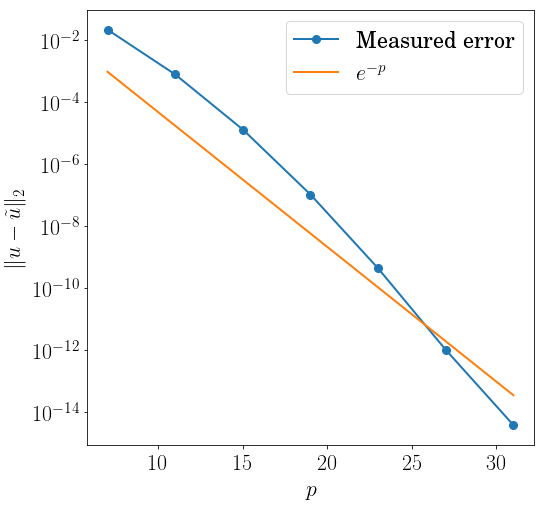

In [95]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.semilogy(plist,erl,'o-',label='Measured error')
ax.semilogy(plist,np.exp(-np.array(plist)),label='$e^{-p}$')
plt.legend()
ax.set_xlabel('$p$')
ax.set_ylabel(r'$\|u-\tilde{u}\|_2$')
plt.savefig('test1pconv.png',bbox_inches='tight')

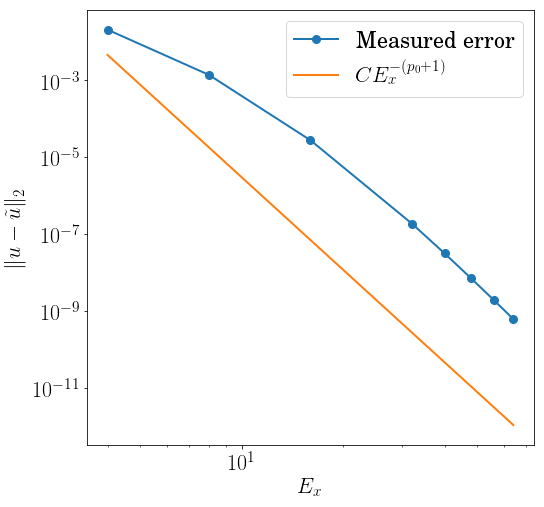

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.loglog(elist,erl,'o-',label='Measured error')
ax.loglog(elist,300.*np.float_power(np.array(elist),-(p0+1)),label='$C E_x^{-(p_0+1)}$')
plt.legend()
ax.set_xlabel('$E_x$')
ax.set_ylabel(r'$\|u-\tilde{u}\|_2$')
plt.savefig('test1Econv.png',bbox_inches='tight')

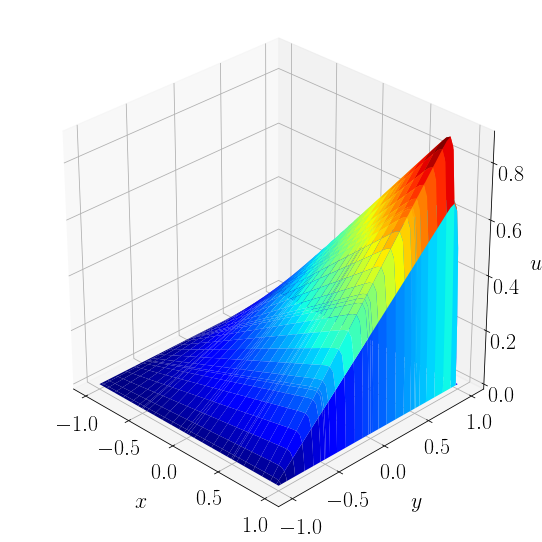

In [107]:
U0 = np.reshape(R.transpose().dot(usln1),(Nx,Ny),order='F')
if(initflg==1):
    print(p0,sl.norm((uex-U0).reshape(-1,order='F'),2))
    sempltsurf(X,Y,U0,cx,cy,xyrot=315)
elif(initflg==2):
    sempltsurf(X,Y,U0+Ub,cx,cy)
elif(initflg==3):
#     sempltsurf(X,Y,uex-U0,cx,cy,xyrot=315,ifplv=False,zlb='$e$')
    sempltsurf(X,Y,U0,cx,cy,xyrot=315,ifplv=False,ifsv=True)
elif(initflg==4):
    sempltsurf(X,Y,U0,cx,cy)
elif(initflg==5):
    sempltsurf(X,Y,U0+Ub,cx,cy)